# Test YOLO model

In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline


In [25]:
yolo_model = YOLO("runs/detect/train/weights/best.pt")

metrics = yolo_model.val(data="datasets/yolo_data/data.yaml", workers=0)

print(f"mAP@0.5: {metrics.box.map50:.4f}")      # mAP@0.5
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")   # mAP@0.5:0.95
print(f"Precision: {metrics.box.mp:.4f}")  
print(f"Recall: {metrics.box.mr:.4f}")      

# Additional metrics
print(f"F1-Score: {2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr):.4f}")
print(f"Fitness: {metrics.fitness:.4f}")

Ultralytics 8.3.162  Python-3.10.13 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 507.5278.7 MB/s, size: 85.6 KB)


val: Scanning E:\AIO2024\OCR\datasets\yolo_data\val\labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


                   all         42        207      0.836      0.826      0.875      0.654
Speed: 0.2ms preprocess, 8.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs\detect\val6
mAP@0.5: 0.8753
mAP@0.5:0.95: 0.6542
Precision: 0.8363
Recall: 0.8261
F1-Score: 0.8312
Fitness: 0.6764



image 1/1 e:\AIO2024\OCR\datasets\yolo_data\test\images\aPICT0020.JPG: 640x640 3 texts, 46.8ms
Speed: 4.8ms preprocess, 46.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


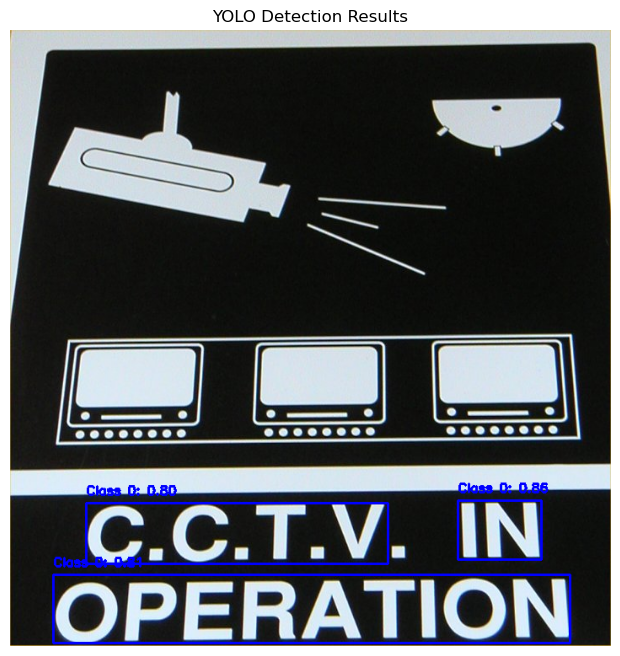

In [26]:
image_path = f"datasets\\yolo_data\\test\\images\\aPICT0020.JPG"

yolo_results = yolo_model(image_path)

for result in yolo_results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
    scores = result.boxes.conf.cpu().numpy()  # Confidence scores
    classes = result.boxes.cls.cpu().numpy()  # Class indices

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)
        label = f"Class {int(cls)}: {score:.2f}"
        cv2.rectangle(result.orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(result.orig_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('YOLO Detection Results')
plt.show()

# Test CRNN model

In [ ]:
from Text_recognition.CRNN import evaluate, CRNN
from rcnn_preprocessing import decode
import torch
import torch.nn as nn
from PIL import Image

In [30]:
checkpoint_path = "crnn/best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Recreate model
device = "cuda" if torch.cuda.is_available() else "cpu"
crnn_model = CRNN(
    vocab_size=checkpoint['vocab_size'],
    hidden_size=checkpoint['hidden_size'],
    n_layers=checkpoint['n_layers'],
    dropout=checkpoint['dropout_prob']
).to(device)
crnn_model.load_state_dict(checkpoint['model_state_dict'])

# Load validation dataloader
from Text_recognition.CRNN import create_dataloaders, get_preprocessing_data
preprocessing_data = get_preprocessing_data()
_, val_loader, _ = create_dataloaders(preprocessing_data)

# Define loss function
criterion = nn.CTCLoss(
    blank=checkpoint['char_to_idx']["-"],
    zero_infinity=True,
    reduction="mean"
)

# Evaluate model on both validation and test sets
val_loss = evaluate(crnn_model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")

# Get test loader and evaluate on test set
_, _, test_loader = create_dataloaders(preprocessing_data)
test_loss = evaluate(crnn_model, test_loader, criterion, device)

print("\nEvaluation on val/test dataset")
print(f"Val loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")

Successfully loaded data using windows-1252 encoding
Total images: 826
Vocab: 0123456789abcdfghijklmopqrstuvwxyzé-
Vocab size: 36
Train set size: 668
Validation set size: 83
Test set size: 75

Example encoding/decoding:
Original label: 36
Encoded: tensor([5, 8, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Length: 2
From [tensor([5, 8, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)] to ['36']
Decoded: 36


Validation Loss: 2.6912



Evaluation on val/test dataset
Val loss: 2.6912
Test loss: 2.6165


Successfully loaded data using windows-1252 encoding
Total images: 826
Vocab: 0123456789abcdfghijklmopqrstuvwxyzé-
Vocab size: 36
Train set size: 668
Validation set size: 83
Test set size: 75

Example encoding/decoding:
Original label: 36
Encoded: tensor([5, 8, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Length: 2
From [tensor([5, 8, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)] to ['36']
Decoded: 36
Detected text regions:
--------------------------------------------------
From tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0') to ['']
Region 1: Box(531,558,630,628) - Confidence: 0.856 - Text: ''
From tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1, 24, 24,  1,  1,  1]], device='cuda:0') to ['o']
Region 2: Box(51,646,664,727) - Confidence: 0.811 - Text: 'o'
From tensor([[24, 24, 24, 24, 24,  1,  1,  1,  1,  1,  1,  1,  1,  1]], device='cuda:0') to ['o']
Region 3: Box(90,561,448,633) - Confidence: 0.801 - Text: 'o'
From tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 

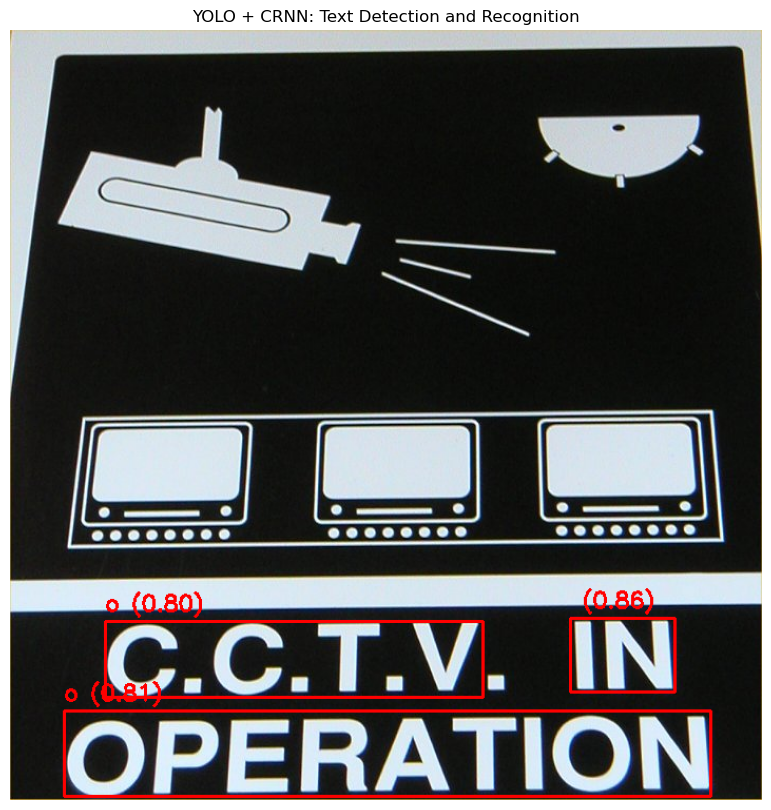

In [31]:
image = cv2.imread(image_path)

# Get preprocessing data for CRNN
preprocessing_data = get_preprocessing_data()
data_transforms = preprocessing_data['data_transforms']['val']
idx_to_char = preprocessing_data['idx_to_char']

print("Detected text regions:")
print("-" * 50)

for i, result in enumerate(yolo_results):
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    
    for j, (box, score) in enumerate(zip(boxes, scores)):
        if score > 0.5:  # Only process high confidence detections
            x1, y1, x2, y2 = map(int, box)
            
            # Crop the detected region
            cropped_region = image[y1:y2, x1:x2]
            
            # Convert to PIL Image and apply transforms
            pil_image = Image.fromarray(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
            transformed_image = data_transforms(pil_image).unsqueeze(0).to(device)
            
            # Predict text using CRNN
            with torch.no_grad():
                output = crnn_model(transformed_image)
                output = output.permute(1, 0, 2)  # Convert back from CTC format
                
                # Get predicted sequence (greedy decoding)
                predicted_sequence = torch.argmax(output, dim=2)
                decoded_text = decode(predicted_sequence, idx_to_char)
                
                print(f"Region {j+1}: Box({x1},{y1},{x2},{y2}) - Confidence: {score:.3f} - Text: '{decoded_text[0]}'")

# Visualize results with predicted text
plt.figure(figsize=(15, 10))
image_rgb = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

for result in yolo_results:
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    
    for box, score in zip(boxes, scores):
        if score > 0.5:
            x1, y1, x2, y2 = map(int, box)
            
            # Draw bounding box
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
            # Crop and predict text
            cropped_region = image[y1:y2, x1:x2]
            pil_image = Image.fromarray(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
            transformed_image = data_transforms(pil_image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = crnn_model(transformed_image)
                output = output.permute(1, 0, 2)
                predicted_sequence = torch.argmax(output, dim=2)
                decoded_text = decode(predicted_sequence, idx_to_char)[0]
            
            # Add predicted text as label
            label = f"{decoded_text} ({score:.2f})"
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

plt.imshow(image_rgb)
plt.axis('off')
plt.title('YOLO + CRNN: Text Detection and Recognition')
plt.show()